In [ ]:
! Date

# 2 photon stimulation analysis


Define the path to the folders containing the data below. 

DO NOT CLICK "RUN ALL". Run each cell (by clicking "shift+enter") until you hit a "STOP" cell. Draw the ROIs (and later the background areas to normalize against), then continue running the notebook. 

Written by Laura Luebbert  
Last updated: Feb 28 17:38:52 PST 2022

### Define the directory containing the tif files (saved by ThorImage software):

In [4]:
data_dir = r"F:\TH\upstairs 2-photon\ss50498 02252022\ss50498_chrtdt 70h05_G6m\female 01 sym\LED_002"

### Define the directory containing the sync files (saved by ThorSync software):

In [5]:
sync_dir = r"F:\TH\upstairs 2-photon\ss50498 02252022\ss50498_chrtdt 70h05_G6m\female 01 sym\LED s002"

### Define directory for pickled dictionary and csv file to be saved to:

In [6]:
saving_dir = r"F:\TH\upstairs 2-photon\ss50498 02252022\ss50498_chrtdt 70h05_G6m\female 01 sym\LED_002\results\for fig"

Now you can start running the notebook until you find a "STOP" cell.

___

___

In [7]:
# %load_ext blackcellmagic
%config InlineBackend.figure_format = 'retina'

In [8]:
# Tools to read in the image files and filenames
import glob
import os
import re 

# Calculation and data frame tools
import numpy as np
import pandas as pd

# Image processing tools
import skimage
import skimage.io
import skimage.morphology

import bebi103

# Tools to create new folders
from pathlib import Path

# Tools to save dictionaries
import pickle

# To make a copy of a dictionary
import copy

# Load hdf5 and xml files into Python
import h5py
import xml.etree.ElementTree as ET

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation

import bokeh
import iqplot
from bokeh.plotting import output_file, save
bokeh.io.output_notebook()

Loading BokehJS ...

___

# Load in the data

In [9]:
# Glob string for images (loads all .tif files)
im_glob = os.path.join(data_dir, "*.tif")
im_glob_preview = os.path.join(data_dir, "*_Preview.tif")
im_glob_chanB = os.path.join(data_dir, "ChanB_*.tif")

# Get list of tif files in data directory (except for the "Preview" tif files and Channel B files - for now)
im_list = sorted([i for i in glob.glob(im_glob) if i not in glob.glob(im_glob_preview) and i not in glob.glob(im_glob_chanB)])

# Let's look at the first 10 entries
im_list[:10]

['F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0001.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0002.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0003.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0004.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0005.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0006.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_0007.tif',
 'F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED_002\\ChanA_001_001_001_000

Create a nested dictionary with information about each sample coupled to the z-stack image matrix, as well as space for matrices added later:

In [10]:
dicts = {}

for i in range(len(im_list)):
    # Get channel
    channel = im_list[i].split("\\")[-1].split("_")[0]
    
    # Make sure we do not overwrite a previous dictionary entry    
    if dicts.get(channel) == None:
        dicts[channel] = {}
    
    # Get sample number
    sample = "_".join(im_list[i].split("\\")[-1].split("_")[1:-1])



   
# Make sure we do not overwrite a previous dictionary entry
    if dicts.get(channel, {}).get(sample) == None:
        
        dicts[channel][sample] = {        
            "matrix_orig": [],       # Original image z-stack matrices
            "df-f0": [],             # Image z-stack matrices showinf df/f0 for each pixel
            "f0_matrix": [],         # Matrix with f0 value of each individual pixel
            "matrix_sum": [],        # Image matrix of sum projection image 
            "df-f0_sum": [],         # df/f0 of each pixel in sum projection
            "filename": [],          # What the max projection will be named when saved locally
            "time_points": [],       # time points in seconds based on fps (counting up from 0)
            "clicks_ROI1": [],            # The coordinates of "clicks" defining the ROI1 
            "clicks_ROI2": [],            # The coordinates of "clicks" defining the ROI2
            "roi1": [],              # ROI clicks converted to an ROI1 (polygon) 
            "roi2": [],              # ROI clicks converted to an ROI2 (polygon) 
            "roi1_mask": [],          # Boolean matrix (mask) in the size of my original image with "True" values where the ROI is
            "roi2_mask": [],          # Boolean matrix (mask) in the size of my original image with "True" values where the ROI is
            "roisbkg_mask": [],      # Boolean matrix (mask) in the size of my original image with "True" values where the ROI is
            "clicks_bkg": [],        # The coordinates of "clicks" defining the background area to normalize against 
            "roisbkg": [],          # bkg area clicks converted to a polygon
            "mean_int_ROI1": [],          # Mean pixel value in ROI1 (not normalized)
            "mean_int_ROI2": [],          # Mean pixel value in ROI2 (not normalized)
            "mean_int_bkg": [],      # Mean pixel value in bkg area
            "mean_int_ROI1_norm":[],      # Mean pixel value in ROI1 - mean pixel value in bkg area
            "mean_int_ROI2_norm":[],      # Mean pixel value in ROI2 - mean pixel value in bkg area
#             "median_int": [],        # Median pixel value in ROI
#             "median_int_bkg": [],    # Median pixel value in bkg area
#             "median_int_norm": [],   # Median pixel value in ROI - median pixel value in bkg area
#             "raw_int_den": [],       # Raw integrated density of ROI (sum of all bkg normalized pixel values inside the ROI) 
#             "int_den": [],           # Integrated density of ROI (product of ROI area and mean bkg normalized pixel value inside the ROI)
#             "mean_fold_change": [],  # (Mean pixel value of ROI (not normalized) - Mean bkg pixel value) / Mean bkg pixel value
#             "median_fold_change": [] # (Median pixel value of ROI (not normalized) - Median bkg pixel value) / Median bkg pixel value
            }

    # Append original image matrices that belong together to form a z-stack
    dicts[channel][sample]["matrix_orig"].append(skimage.io.imread(im_list[i],is_ome=False))
    
    # Populate dictionary with original filename (without information automatically added by microscope)
    dicts[channel][sample]["filename"] = channel + "_" + sample

___

# Extract stimulation data from experiment files

Extract sample rate from xml file in sync folder:

In [11]:
# Glob string for xml file in sync folder (loads only ThorRealTimeDataSettings file)
rtd_glob = os.path.join(sync_dir, "ThorRealTimeDataSettings.xml")

rtd_file = glob.glob(rtd_glob)

Define function to extract sample rate from ThorRealTimeDataSettings.xml file (written by Peter Weir):

In [12]:
def get_sample_rate(inFileName):
    """Finds sample rate for a ThorSync .xml file
    usage:
    sampleRateHz = parse_thor_xml.get_sample_rate(inFileName)

    PTW 2015-08-07"""
    tree = ET.parse(inFileName)
    root = tree.getroot()
    for child in root:
        if child.tag == 'DaqDevices':
            for grandchild in child:
                if grandchild.tag == 'AcquireBoard' and grandchild.attrib['active'] == '1':
                    for greatgrandchild in grandchild:
                        if greatgrandchild.tag == 'SampleRate' and greatgrandchild.attrib['enable'] == '1':
                            sampleRateHz = float(greatgrandchild.attrib['rate'])
                            break

    return sampleRateHz

In [13]:
sampleRateHz = get_sample_rate(rtd_file[0])

In [14]:
sampleRateHz

30000.0

Get hdf5 file from sync folder:

In [15]:
# Glob string for hdf5 files in sync folder (loads only Episode001 file)
sync_glob = os.path.join(sync_dir, "Episode001.h5")

sync_file = glob.glob(sync_glob)
sync_file

['F:\\TH\\upstairs 2-photon\\ss50498 02252022\\ss50498_chrtdt 70h05_G6m\\female 01 sym\\LED s002\\Episode001.h5']

In [16]:
sync = h5py.File(sync_file[0], 'r')

In [17]:
# Hdf5 files behave like dictionaries. List the keys in this hdf5 file:
list(sync.keys())

['AI', 'CI', 'DI', 'Freq', 'Global']

In [18]:
# List keys inside "DI"
list(sync['DI'].keys())

['FrameIn', 'FrameOut', 'Line0', 'SignalGenerator']

Extract FrameOut to find time axis in seconds:

In [19]:
frames = sync['DI']['FrameOut'][:].squeeze()

Compute time in seconds from "dirty" frames:

In [20]:
timeSec = np.arange(len(frames))/sampleRateHz

Plot frames over time before cleanup:

Text(0, 0.5, 'FrameOut')

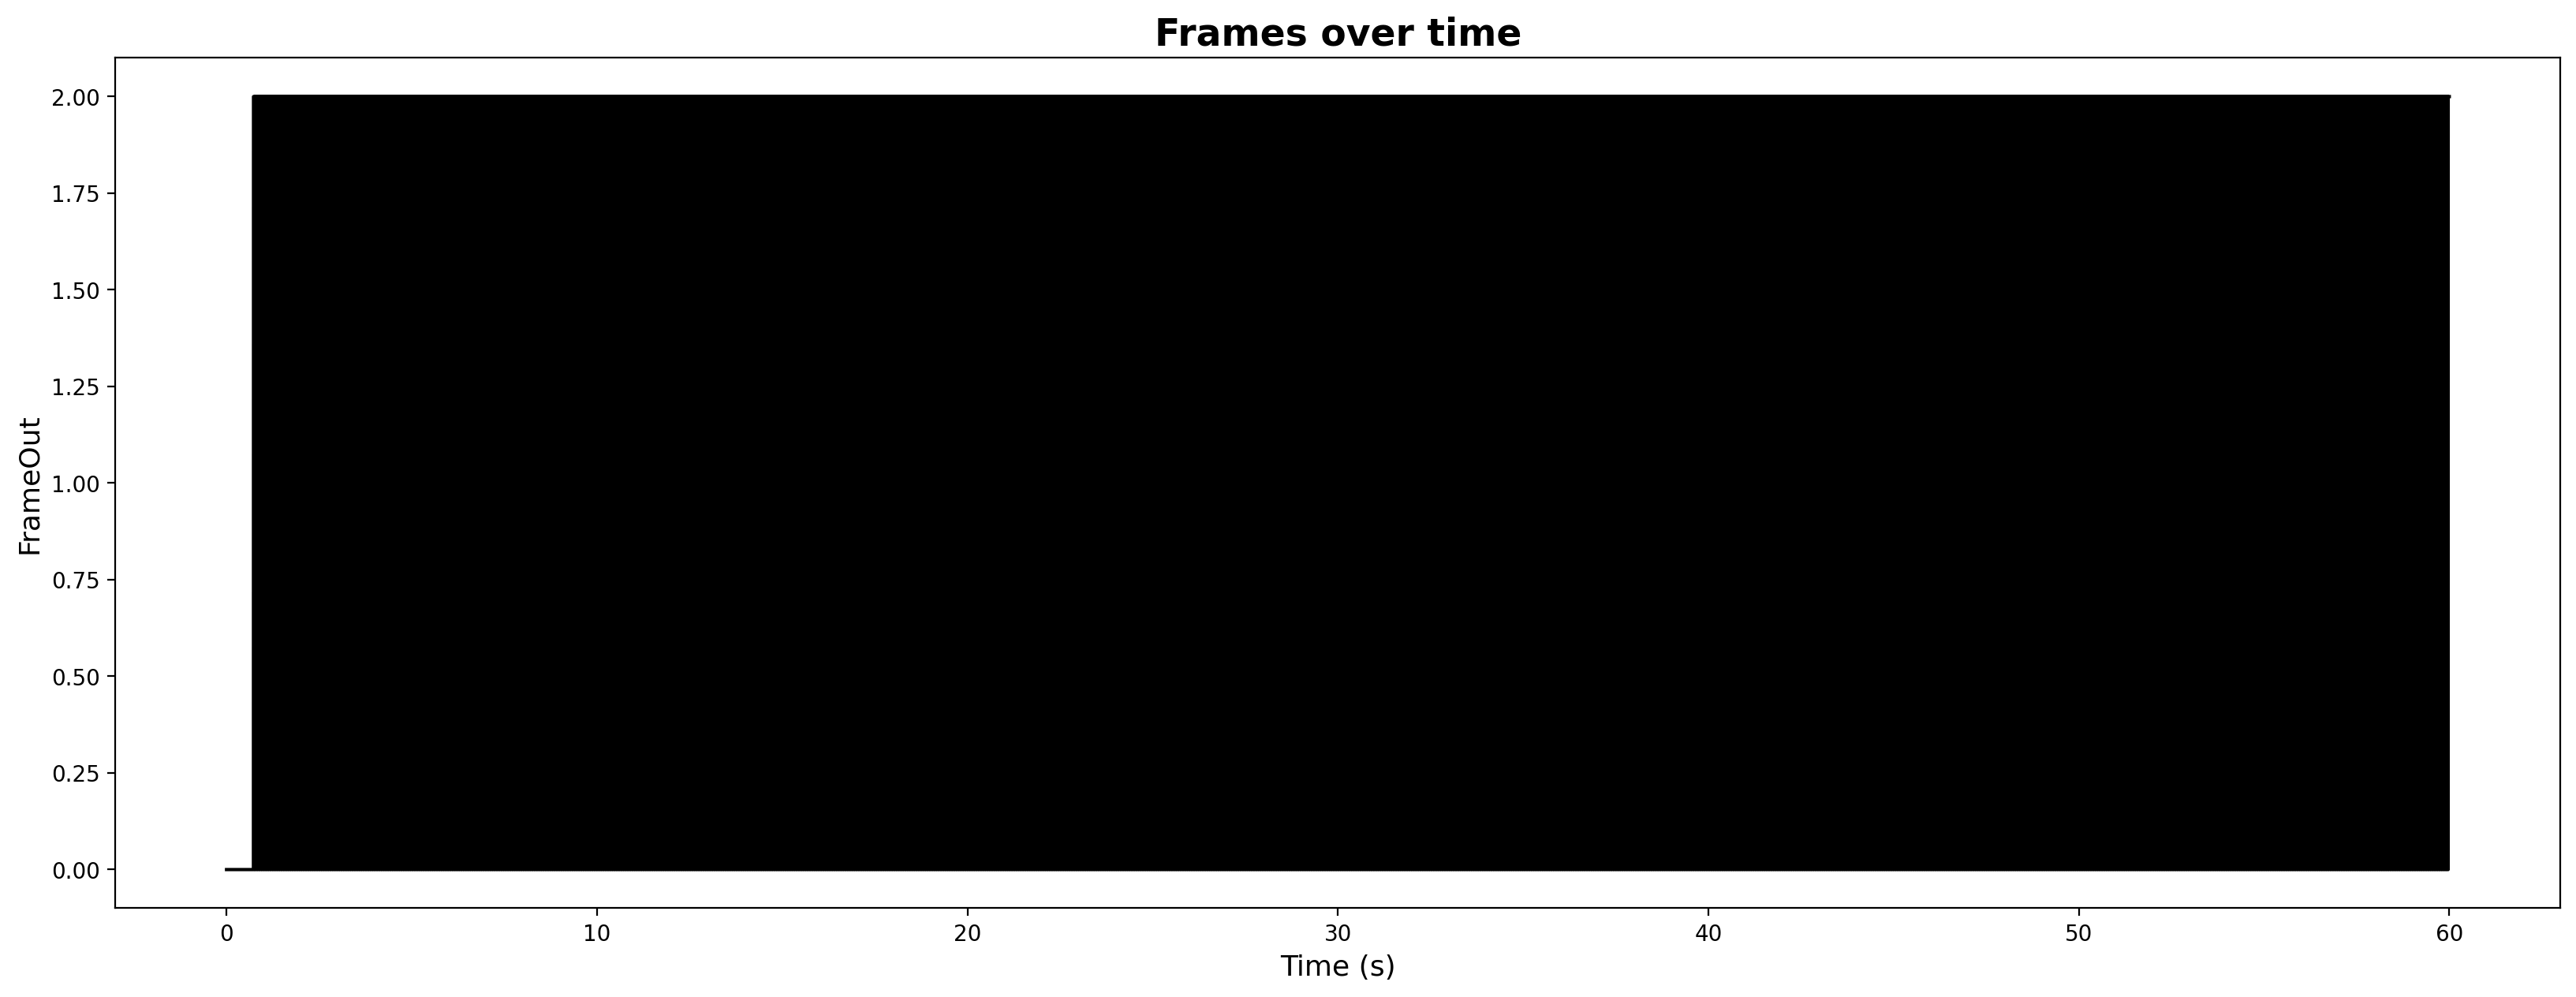

In [21]:
x = timeSec
y = frames

color = "black"

fig, ax = plt.subplots(figsize=(20, 7))

plt.plot(x, y, c=color)

# Define figure title
ax.set_title('Frames over time', weight='bold', size=17)

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight':fontweight, 'size':fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel('FrameOut', fontproperties)

Clean up frames by removing 0s at the start and end of the recording IF there is a tail:

In [22]:
# Define whether or not there is a tail
start_tail = True
end_tail = False

In [23]:
if start_tail == True:
    # Find first occurence of non-zero number in frames
    for i, value in enumerate(frames):
        if (value != 0):
            start_idx = i
            break
else:
    # If not tail at start, use first index so nothing is removed from start
    start_idx = 0

In [24]:
if end_tail == True:        
    # Same on reversed array to find first occurence of non-zero number from end         
    for i, value in enumerate(frames[::-1]):
        if (value != 0):
            end_idx = i
            break
        
else:
    # If not tail at end, set to 1 (will be -1) so nothing is removed from end
    end_idx = 1

In [25]:
# Slice out 0s at beginning and end
frames = frames[start_idx:-end_idx]

Compute time in seconds from clean frames:

In [26]:
timeSec = np.arange(len(frames))/sampleRateHz

Plot frames over time after cleanup:

Text(0, 0.5, 'FrameOut')

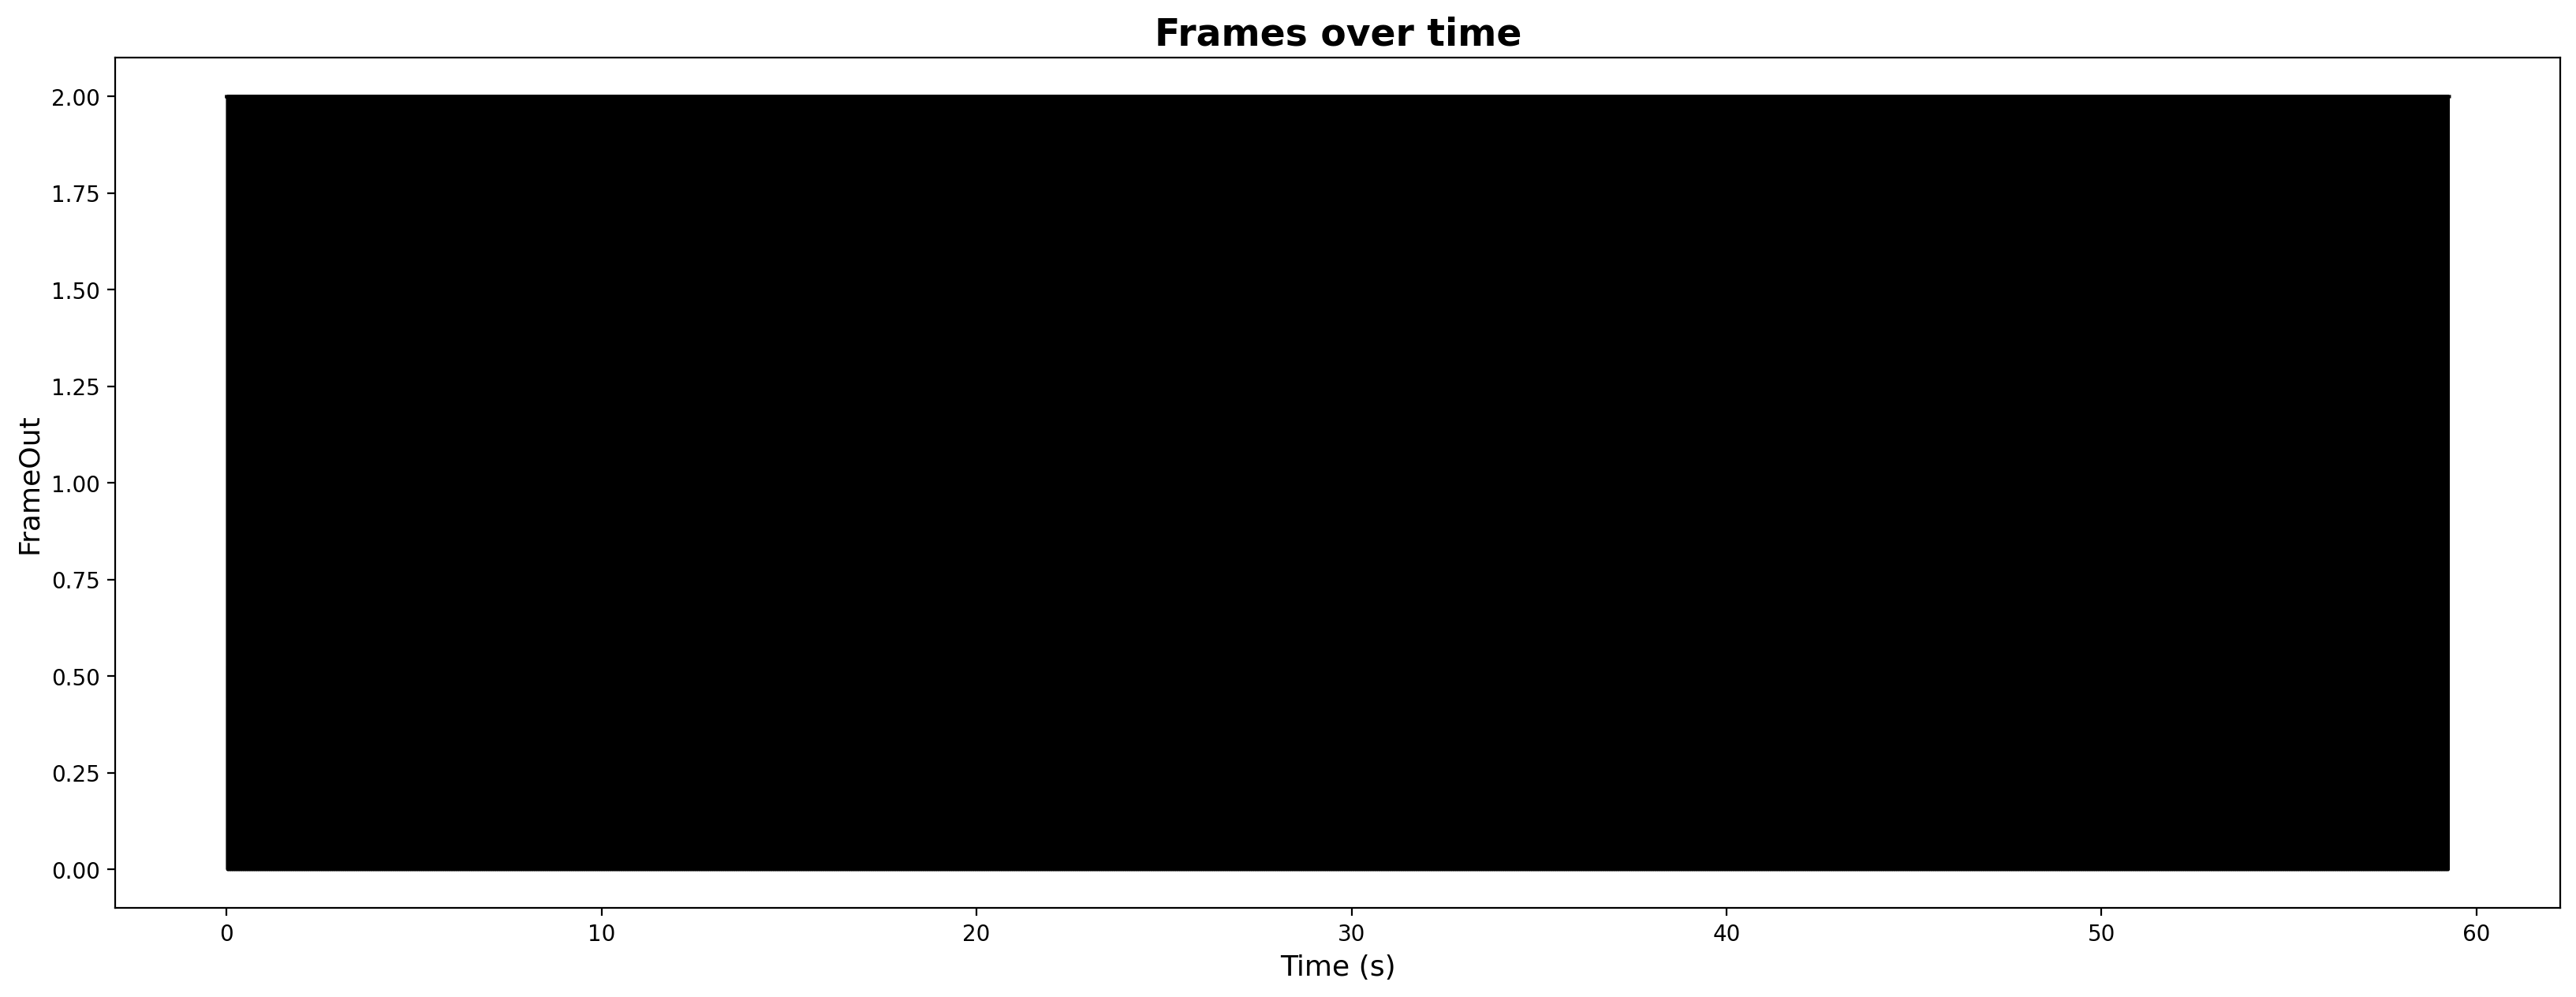

In [27]:
x = timeSec
y = frames

color = "black"

fig, ax = plt.subplots(figsize=(20, 7))

plt.plot(x, y, c=color)

# Define figure title
ax.set_title('Frames over time', weight='bold', size=17)

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight':fontweight, 'size':fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel('FrameOut', fontproperties)

Extract BleachOut channel data (channel used to save LED stimulus):

In [28]:
led = sync['DI']['SignalGenerator'][:].squeeze()
# Slice out parts without frames
led = led[start_idx:-end_idx]

Plot LED stimulation trace over time (in seconds):

Text(0, 0.5, 'LED')

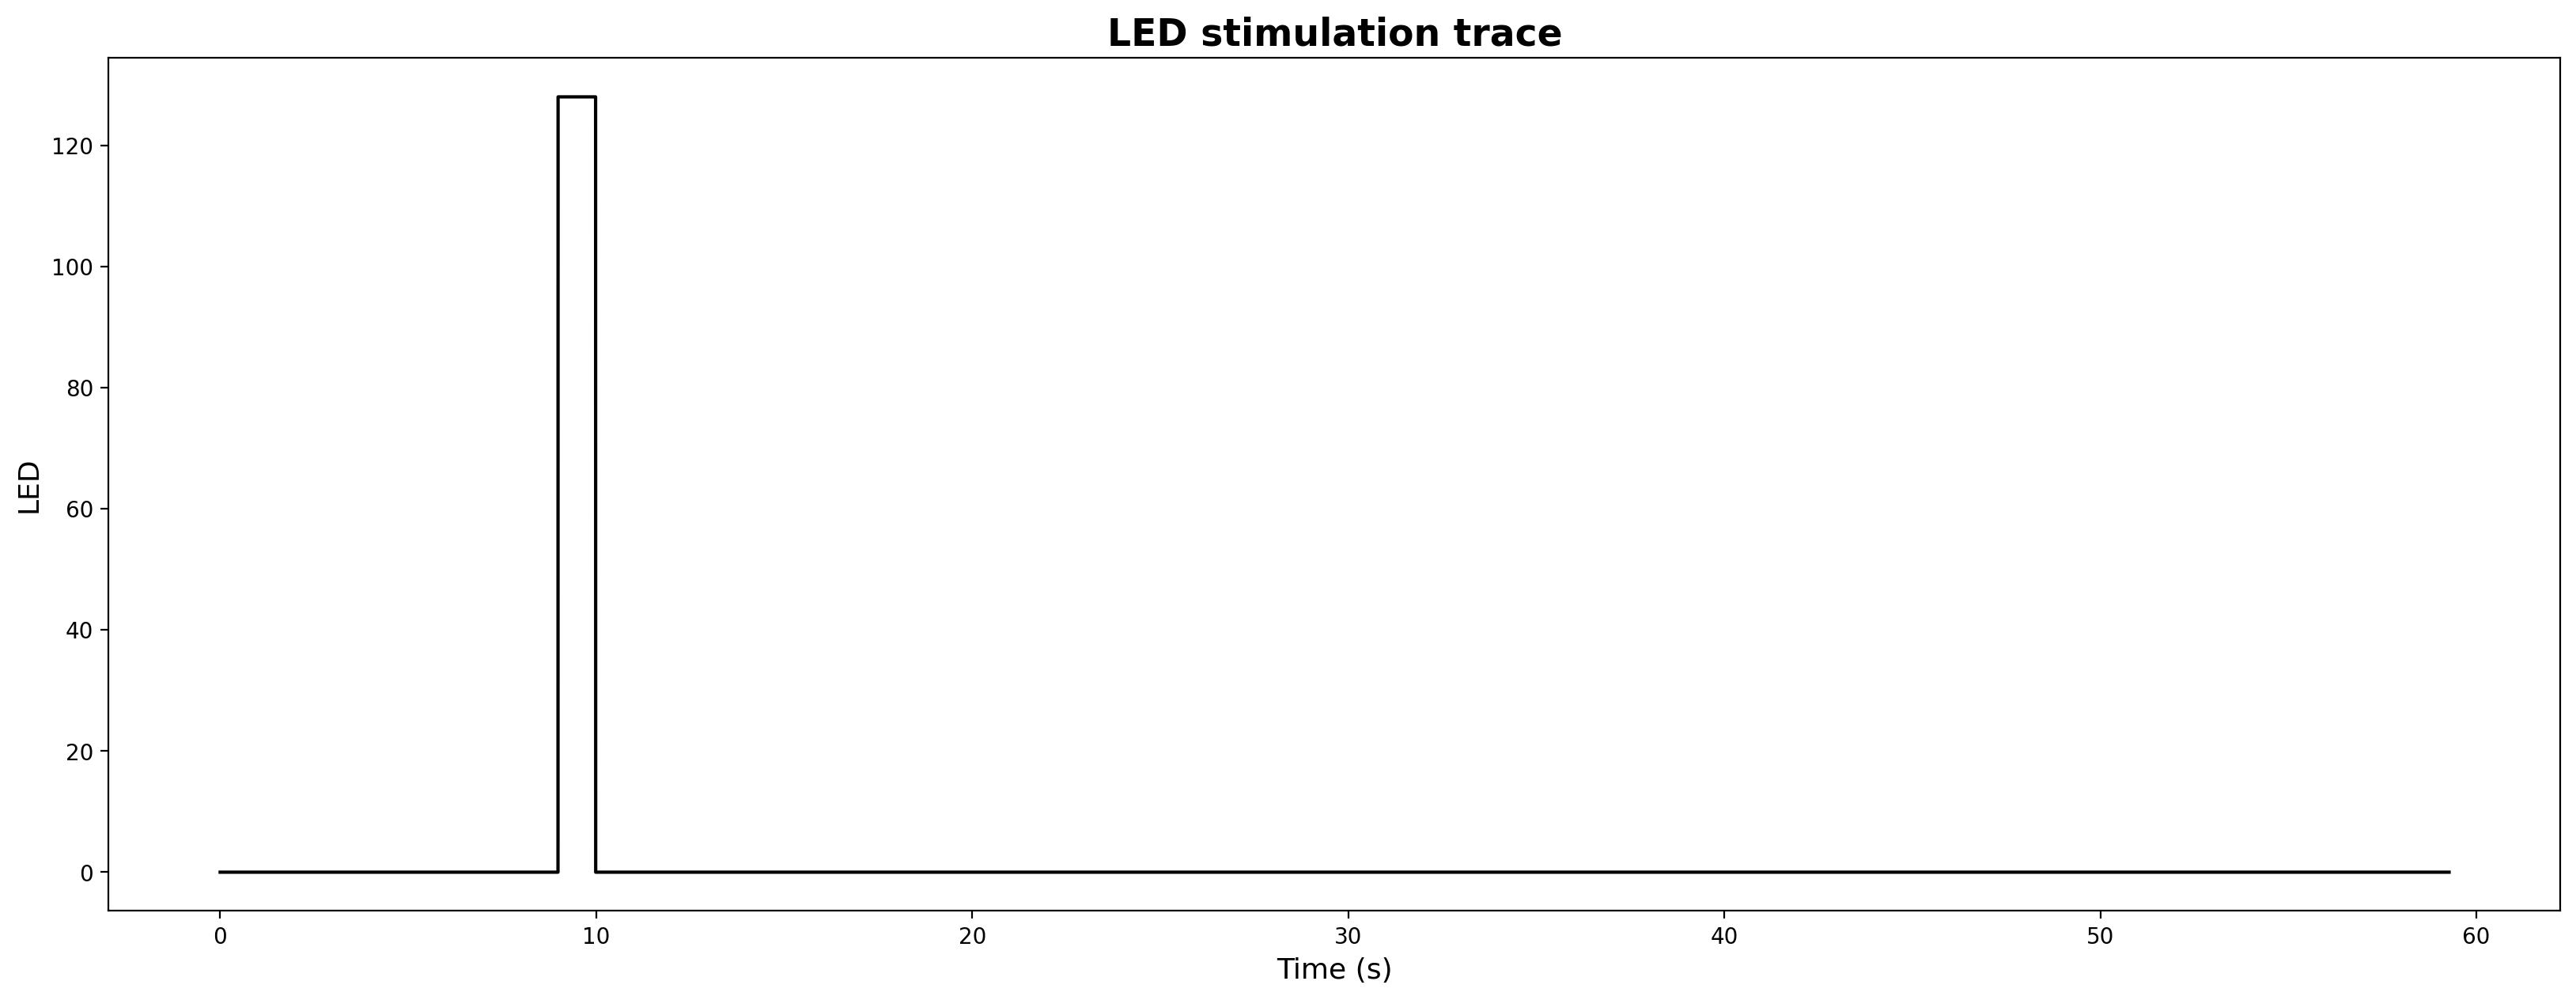

In [29]:
x = timeSec
y = led

color = "black"

fig, ax = plt.subplots(figsize=(20, 7))

plt.plot(x, y, c=color)

# Define figure title
ax.set_title('LED stimulation trace', weight='bold', size=17)

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight':fontweight, 'size':fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel('LED', fontproperties)

Find time points where the LED turned on and off:

In [30]:
# Convert unsigned interger lists to signed
led = led.astype(int)
timeSec = timeSec.astype(float)

In [31]:
# Find time points when the next minus the previous value is > or < 0, and append to led_on and led_off, respectively
led_on = []
led_off = []

for idx, value in enumerate(led[:-1]):
    if led[idx+1] - value > 0:
        led_on.append(timeSec[idx])
        
    if led[idx+1] - value < 0:
        led_off.append(timeSec[idx])

In [32]:
led_on

[8.984666666666667]

In [33]:
led_off

[9.984766666666667]

Calculate frame rate (by dividing the number of frames in the last saved sample by duration of the sync file):

In [34]:
fps = len(dicts[channel][sample]["matrix_orig"])/timeSec.max()
fps

30.367241169881094

In [35]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        # Populate dictionary with time points
        t = np.arange(len(imagedata["matrix_orig"])) / fps

        imagedata["time_points"] = t    



___
# Compute Sum projection for ROI drawing

Compute sum of frames for each image:

In [36]:

for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        # Convert dict entry to array
        image = np.array(imagedata["matrix_orig"])

        # Sum z-project using numpy by definining the axis over which to sum the elements.
        summed_image = image.sum(axis=0)

        # Linearly scale down to 16-bit.
        summed_image = (summed_image/summed_image.max())*65535


         # Convert to uint16
        summed_image = np.uint16(summed_image)

        
        # Save summed image to dictionary
        imagedata["matrix_sum"] = summed_image


        filename = os.path.basename(imagedata["filename"])
        
         # Construct the filename
        new_filename = "{}_sum_projection_{}.png".format(data_dir.split("\\")[-1], filename)
        full_path = os.path.join(saving_dir, new_filename)
        
 #       skimage.io.imsave(
 #           full_path,
 #           summed_image,
 #           plugin=None,
 #           check_contrast=False,
 #       )
        skimage.io.imsave(full_path, 
            summed_image, 
            plugin=None,
            check_contrast=False,
        )



## Define two ROIs : ROI1

In [37]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        image_data = imagedata["matrix_sum"]
        height, width = image_data.shape
        
        temp_ROI1 = bebi103.image.record_clicks(
            image_data,
            frame_height=800, frame_width=800,
            title=os.path.basename(imagedata["filename"]),
            flip=False,
            x_range=(0, width),
            y_range=(0, height)
        )
        
        # Save clicks to dictionary
        imagedata["clicks_ROI1"] = temp_ROI1

# STOP

Convert clicks to a tidy data frame:

In [38]:
roi1_for_polygon = []

for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        temp = imagedata["clicks_ROI1"].to_df()

        # Add "roi" column (in this case there is just one ROI per sample with number "0")
        temp["roi1"] = 0

        # Save clicks to dictionary as tidy data frame (this will overwrite the previously saved version of the clicks!)
        imagedata["clicks_ROI1"] = temp
        
        # Save temp for plotting of ROI in heatmap animation
        roi1_for_polygon.append(temp)

Use the bebi103.image.verts_to_roi function to convert the set of vertices (clicks) that define a polygon to a region of interest (the inside of the polygon):

In [39]:
import numpy as np
from matplotlib.path import Path
import skimage.measure

def custom_verts_to_roi(verts, size_i, size_j):
    """
    Custom implementation of verts_to_roi to avoid np.bool deprecation.
    Returns three values: full ROI mask, bounding box, and ROI within bounding box.
    """
    # Make sure verts are float
    verts = verts.astype(float)
    
    # Make sure first and last vertex are the same
    if not np.allclose(verts[0], verts[-1]):
        verts = np.vstack((verts, verts[0]))
   
    # Make a Path object
    p = Path(verts)
   
    # Make a grid of points
    i = np.arange(size_i)
    j = np.arange(size_j)
    ii, jj = np.meshgrid(j, i)
    pts = np.array([ii.ravel(), jj.ravel()]).T
   
    # Get points that are inside the polygon
    in_roi = p.contains_points(pts)
   
    # Convert it to an image
    roi = in_roi.reshape((size_i, size_j)).astype(bool)

    # Get bounding box of ROI
    regions = skimage.measure.regionprops(roi.astype(np.int32))
   
    if len(regions) == 0:
        return roi, (0, 0, size_i, size_j), roi
    bbox = regions[0].bbox
    return roi, bbox, roi[bbox[0]:bbox[2], bbox[1]:bbox[3]]





# Now use this function in your main code
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        # Check if 'clicks_ROI1' exists and is not empty
        if 'clicks_ROI1' in imagedata and not imagedata['clicks_ROI1'].empty:
            imagedata["roi1"] = [
                custom_verts_to_roi(
                    g[['x', 'y']].values,
                    imagedata["matrix_sum"].shape[0],
                    imagedata["matrix_sum"].shape[1]
                )
                for _, g in imagedata["clicks_ROI1"].groupby('roi1')
            ]
        else:
            print(f"Warning: No clicks data for ROI1 in {k1_channel}, {k2_sample}")
            imagedata["roi1"] = []

# The rest of your code for checking and visualizing the ROIs should now work correctly
plots = []
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        if imagedata["roi1"]:  # Check if there are any ROIs
            roi_1, roi_1_bbox, roi_1_box = imagedata["roi1"][0]
            
            imagedata["roi1_mask"] = roi_1
            # Make grayscale image that is now RGB/CMY
            im = np.dstack(3 * [skimage.img_as_float(imagedata["matrix_sum"])])
            # Max out first channel
            im[roi_1, 0] = im.max()
            plots.append(
                bebi103.image.imshow(
                    im,
                    title="{}_roi_1".format(imagedata["filename"]),
                    frame_height=250,
                    cmap="rgb",
                    flip=True,
                )
            )
        else:
            print(f"Warning: No ROI data for {k1_channel}, {k2_sample}")

# Look at the images
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

import os
import bokeh.io

for idx, plot in enumerate(plots):
    # Get the base name of the data directory
    data_dir_name = os.path.basename(data_dir)
    
    # Construct the filename
    new_filename = f"{data_dir_name}_roi1_{idx}.png"
    full_path = os.path.join(saving_dir, new_filename)
    
    # Export the plot as PNG
    bokeh.io.export_png(plot, 
                        filename=full_path,
                        width=25000, height=25000)

 

Check that the ROIs are correct:

Calculate mean and median fluorescence value in ROI1 (not normalized against bkg):

In [40]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        
        roi_1, roi_1_bbox, roi_1_box = imagedata["roi1"][0]
        im = imagedata["matrix_orig"]
        
        for stack in im:
            # Calculate mean and median intensity inside ROI for each individual stack
            mean_int_ROI1 = stack[roi_1].mean()
#             median_int = np.median(stack[roi])

            # Append to dictionary
            imagedata["mean_int_ROI1"].append(mean_int_ROI1)
#             imagedata["median_int_ROI1"].append(median_int_ROI1)

## Define ROI2

In [41]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        image_data = imagedata["matrix_sum"]
        height, width = image_data.shape
        
        temp_ROI2 = bebi103.image.record_clicks(
            image_data,
            frame_height=800, frame_width=800,
            title=os.path.basename(imagedata["filename"]),
            flip=False,
            x_range=(0, width),
            y_range=(0, height)
        )
        
        # Save clicks to dictionary
        imagedata["clicks_ROI2"] = temp_ROI2

# STOP

Convert clicks to a tidy data frame:

In [42]:
roi2_for_polygon = []

for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        temp = imagedata["clicks_ROI2"].to_df()

        # Add "roi" column (in this case there is just one ROI per sample with number "0")
        temp["roi2"] = 0

        # Save clicks to dictionary as tidy data frame (this will overwrite the previously saved version of the clicks!)
        imagedata["clicks_ROI2"] = temp
        
        # Save temp for plotting of ROI in heatmap animation
        roi2_for_polygon.append(temp)



Use the bebi103.image.verts_to_roi function to convert the set of vertices (clicks) that define a polygon to a region of interest (the inside of the polygon):

In [43]:
import numpy as np
from matplotlib.path import Path
import skimage.measure

def custom_verts_to_roi(verts, size_i, size_j):
    """
    Custom implementation of verts_to_roi to avoid np.bool deprecation.
    Returns three values: full ROI mask, bounding box, and ROI within bounding box.
    """
    # Make sure verts are float
    verts = verts.astype(float)
    
    # Make sure first and last vertex are the same
    if not np.allclose(verts[0], verts[-1]):
        verts = np.vstack((verts, verts[0]))
        
    # Make a Path object
    p = Path(verts)
    
    # Make a grid of points
    i = np.arange(size_i)
    j = np.arange(size_j)
    ii, jj = np.meshgrid(j, i)
    pts = np.array([ii.ravel(), jj.ravel()]).T
    
    # Get points that are inside the polygon
    in_roi = p.contains_points(pts)
    
    # Convert it to an image
    roi = in_roi.reshape((size_i, size_j)).astype(bool)
    
  # Get bounding box of ROI
    regions = skimage.measure.regionprops(roi.astype(np.int32))

    if len(regions) == 0:
        return roi, (0, 0, size_i, size_j), roi
    bbox = regions[0].bbox
    return roi, bbox, roi[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Now use this function in your main code
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        # Check if 'clicks_ROI2' exists and is not empty
        if 'clicks_ROI2' in imagedata and not imagedata['clicks_ROI2'].empty:
            imagedata["roi2"] = [
                custom_verts_to_roi(
                    g[['x', 'y']].values,
                    imagedata["matrix_sum"].shape[0],
                    imagedata["matrix_sum"].shape[1]
                )
                for _, g in imagedata["clicks_ROI2"].groupby('roi2')
            ]
        else:
            print(f"Warning: No clicks data for ROI2 in {k1_channel}, {k2_sample}")
            imagedata["roi2"] = []

# The rest of your code for checking and visualizing the ROIs
plots = []
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        if imagedata["roi2"]:  # Check if there are any ROIs
             roi_2, roi_2_bbox, roi_2_box = imagedata["roi2"][0]
            
             imagedata["roi2_mask"] = roi_2
            # Make grayscale image that is now RGB/CMY
             im = np.dstack(3 * [skimage.img_as_float(imagedata["matrix_sum"])])
            # Max out first channel
             im[roi_2, 0] = im.max()
             plots.append(
                bebi103.image.imshow(
                    im,
                    title="{}_roi_2".format(imagedata["filename"]),
                    frame_height=250,
                    cmap="rgb",
                    flip=True,
                )
            )
        else:
            print(f"Warning: No ROI data for {k1_channel}, {k2_sample}")

# Look at the images
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

import os
import bokeh.io

for idx, plot in enumerate(plots):
    # Get the base name of the data directory
    data_dir_name = os.path.basename(data_dir)
    
    # Construct the filename
    new_filename = f"{data_dir_name}_roi2_{idx}.png"
    full_path = os.path.join(saving_dir, new_filename)
    
    # Export the plot as PNG
    bokeh.io.export_png(plot, 
                        filename=full_path,
                        width=25000, height=25000)

  

Check that the ROIs are correct:

Calculate mean and median fluorescence value in ROI2 (not normalized against bkg):

In [44]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        
        # Check if roi2 exists and is not empty
       
            roi_2, roi_2_bbox, roi_2_box = imagedata["roi2"][0]  # This is just the mask now
            im = imagedata["matrix_orig"]
            
          
            for stack in im:
                # Calculate mean intensity inside ROI for each individual stack
                mean_int_ROI2 = stack[roi_2].mean()
                # Append to dictionary
                imagedata["mean_int_ROI2"].append(mean_int_ROI2)
                
            # If you need median intensity, uncomment these lines:
            # if "median_int_ROI2" not in imagedata:
            #     imagedata["median_int_ROI2"] = []
            # median_int_ROI2 = np.median(stack[roi_2])
            # imagedata["median_int_ROI2"].append(median_int_ROI2)
       

# Define background area

Define a small square outside of the ROI which is representative of the background fluorescence.

In [45]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        image_data = imagedata["matrix_sum"]
        height, width = image_data.shape
        
        temp_bkg = bebi103.image.record_clicks(
            image_data,
            frame_height=800, frame_width=800,
            title=os.path.basename(imagedata["filename"]),
            flip=False,
            x_range=(0, width),
            y_range=(0, height)
        )


        # Save clicks to dictionary
        imagedata["clicks_bkg"] = temp_bkg



# STOP

Convert clicks to a tidy data frame:

In [46]:

bk_for_polygon = []

for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        temp = imagedata["clicks_bkg"].to_df()

        # Add "roi" column (in this case there is just one ROI per sample with number "0")
        temp["roisbkg"] = 0

        # Save clicks to dictionary as tidy data frame (this will overwrite the previously saved version of the clicks!)
        imagedata["clicks_bkg"] = temp
        
        # Save temp for plotting of ROI in heatmap animation
        bk_for_polygon.append(temp)




Use the bebi103.image.verts_to_roi function to convert the set of vertices (clicks) that define a polygon to a region of interest (the inside of the polygon):

In [47]:
import numpy as np
from matplotlib.path import Path
import skimage.measure

def custom_verts_to_roi(verts, size_i, size_j):
    """
    Custom implementation of verts_to_roi to avoid np.bool deprecation.
    Returns only the ROI mask.
    """
    # Make sure verts are float
    verts = verts.astype(float)
    
    # Make sure first and last vertex are the same
    if not np.allclose(verts[0], verts[-1]):
        verts = np.vstack((verts, verts[0]))
   
    # Make a Path object
    p = Path(verts)
   
    # Make a grid of points
    i = np.arange(size_i)
    j = np.arange(size_j)
    ii, jj = np.meshgrid(j, i)
    pts = np.array([ii.ravel(), jj.ravel()]).T
   
    # Get points that are inside the polygon
    in_roi = p.contains_points(pts)
   
    # Convert it to an image
    roi = in_roi.reshape((size_i, size_j)).astype(bool)
  
    # Get bounding box of ROI
    regions = skimage.measure.regionprops(roi.astype(np.int32))

    if len(regions) == 0:
        return roi, (0, 0, size_i, size_j), roi

    bbox = regions[0].bbox

    return roi, bbox, roi[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Now use this function in your main code
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        # Check if 'clicks_bkg' exists and is not empty
        if 'clicks_bkg' in imagedata and not imagedata['clicks_bkg'].empty:
            imagedata["roisbkg"] = [
                custom_verts_to_roi(
                    g[['x', 'y']].values,
                    imagedata["matrix_sum"].shape[0],
                    imagedata["matrix_sum"].shape[1]
                )
                for _, g in imagedata["clicks_bkg"].groupby('roisbkg')
            ]
        else:
            print(f"Warning: No clicks data for background ROI in {k1_channel}, {k2_sample}")
            imagedata["roisbkg"] = []

# The rest of your code for checking and visualizing the ROIs
plots = []
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        if imagedata["roisbkg"]:  # Check if there are any ROIs
            roi_bkg, roi_bkg_bbox, roi_bkg_box = imagedata["roisbkg"][0]
            
            imagedata["roisbkg_mask"] = roi_bkg
            # Make grayscale image that is now RGB/CMY
            im = np.dstack(3 * [skimage.img_as_float(imagedata["matrix_sum"])])
            # Max out first channel
            im[roi_bkg, 0] = im.max()
            plots.append(
                bebi103.image.imshow(
                    im,
                    title="{}_roi_bkg".format(imagedata["filename"]),
                    frame_height=250,
                    cmap="rgb",
                    flip=True,
                )
            )
        else:
            print(f"Warning: No ROI data for {k1_channel}, {k2_sample}")

# Look at the images
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=3))

import os
import bokeh.io

for idx, plot in enumerate(plots):
    # Get the base name of the data directory
    data_dir_name = os.path.basename(data_dir)
    
    # Construct the filename
    new_filename = f"{data_dir_name}_roisbkg_{idx}.png"
    full_path = os.path.join(saving_dir, new_filename)
    
    # Export the plot as PNG
    bokeh.io.export_png(plot, 
                        filename=full_path,
                        width=25000, height=25000)
    
 

Check that the ROIs are correct:

Calculate mean and median fluorescence values in background area for each stack:

In [48]:


for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        
        roi_bkg, roi_bkg_bbox, roi_bkg_box = imagedata["roisbkg"][0]
        im = imagedata["matrix_orig"]
        
        for stack in im:
            # Calculate mean and median intensity inside bkg area for each individual stack
            mean_int_bkg = stack[roi_bkg].mean()
#             median_int_bkg = np.median(stack[roi])

            # Append to dictionary
            imagedata["mean_int_bkg"].append(mean_int_bkg)
#             imagedata["median_int_bkg"].append(median_int_bkg)

___

# Compute background normalized fluorescence values in each stack

In [49]:
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        
        roi_bkg, roi_bkg_bbox, roi_bkg_box = imagedata["roisbkg"][0]
        im = imagedata["matrix_orig"]
        
        
        for i, stack in enumerate(im):
            
            # Get mean and median pixel values of ROI and bkg fo stack
            int_mean_ROI1 = imagedata["mean_int_ROI1"][i]
            int_mean_ROI2 = imagedata["mean_int_ROI2"][i]
            bkg_mean = imagedata["mean_int_bkg"][i]

            # Compute BG substracted mean and median pixel values in ROI1 for each stack
            norm_int_mean_ROI1 = int_mean_ROI1 - bkg_mean
            if norm_int_mean_ROI1 < 0:
                imagedata["mean_int_ROI1_norm"].append(norm_int_mean_ROI1)
            else: 
                imagedata["mean_int_ROI1_norm"].append(norm_int_mean_ROI1)
                
            # Compute BG substracted mean and median pixel values in ROI2 for each stack
            norm_int_mean_ROI2 = int_mean_ROI2 - bkg_mean
            if norm_int_mean_ROI2 < 0:
                imagedata["mean_int_ROI2_norm"].append(norm_int_mean_ROI2)
            else: 
                imagedata["mean_int_ROI2_norm"].append(norm_int_mean_ROI2)
            

    print(f"Channel: {k1_channel}, Sample: {k2_sample}")
    print(f"int_mean_ROI1: { imagedata["mean_int_ROI1"][i]}")
    print(f"int_mean_ROI2: { imagedata["mean_int_ROI2"][i]}")
    print(f"bkg_mean: { imagedata["mean_int_bkg"][i]}")
    print("---")

Channel: ChanA, Sample: 001_001_001
int_mean_ROI1: 560.3764705882353
int_mean_ROI2: 566.3190578158458
bkg_mean: 566.351282051282
---


___

# Create a data frame and csv file for comparison of pixel values across conditions

In [50]:
import pandas as pd

df_list = []
for k1_channel, v1_sample in dicts.items():
    for k2_sample, imagedata in v1_sample.items():
        x = 1
        for i, stack in enumerate(imagedata["matrix_orig"]):
            df_list.append({
                "Filename": imagedata["filename"],
                "Channel": k1_channel,
                "Sample": k2_sample,
                "Time": imagedata["time_points"][i],
                "Frame": x,
                "Channel + Sample": f"{k1_channel} ({k2_sample})",
                "Mean pixel value in ROI1": imagedata["mean_int_ROI1"][i],
                "Mean pixel value in ROI2": imagedata["mean_int_ROI2"][i],
                "Mean pixel value in bkg area": imagedata["mean_int_bkg"][i],
                "Norm_mean_pixel_value_in_ROI1": imagedata["mean_int_ROI1_norm"][i],
                "Norm_mean_pixel_value_in_ROI2": imagedata["mean_int_ROI2_norm"][i],
            })
            x += 1

df = pd.DataFrame(df_list)

In [51]:
# Display top of data frame
df.head()

,Filename,Channel,Sample,Time,Frame,Channel + Sample,Mean pixel value in ROI1,Mean pixel value in ROI2,Mean pixel value in bkg area,Norm_mean_pixel_value_in_ROI1,Norm_mean_pixel_value_in_ROI2
0,ChanA_001_001_001,ChanA,001_001_001,0.000000,1,ChanA (001_001_001),562.860504,571.518201,556.144872,6.715632,15.373329
1,ChanA_001_001_001,ChanA,001_001_001,0.032930,2,ChanA (001_001_001),561.885714,560.274090,562.223077,-0.337363,-1.948987
2,ChanA_001_001_001,ChanA,001_001_001,0.065860,3,ChanA (001_001_001),559.332773,567.278373,561.191026,-1.858253,6.087347
3,ChanA_001_001_001,ChanA,001_001_001,0.098791,4,ChanA (001_001_001),563.163025,561.239829,558.211538,4.951487,3.028290
4,ChanA_001_001_001,ChanA,001_001_001,0.131721,5,ChanA (001_001_001),560.915966,565.880086,559.406410,1.509556,6.473675


___

# Plot raw mean fluorescence values over time

C:\Users\raymo\AppData\Local\Temp\ipykernel_127044\2099856697.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


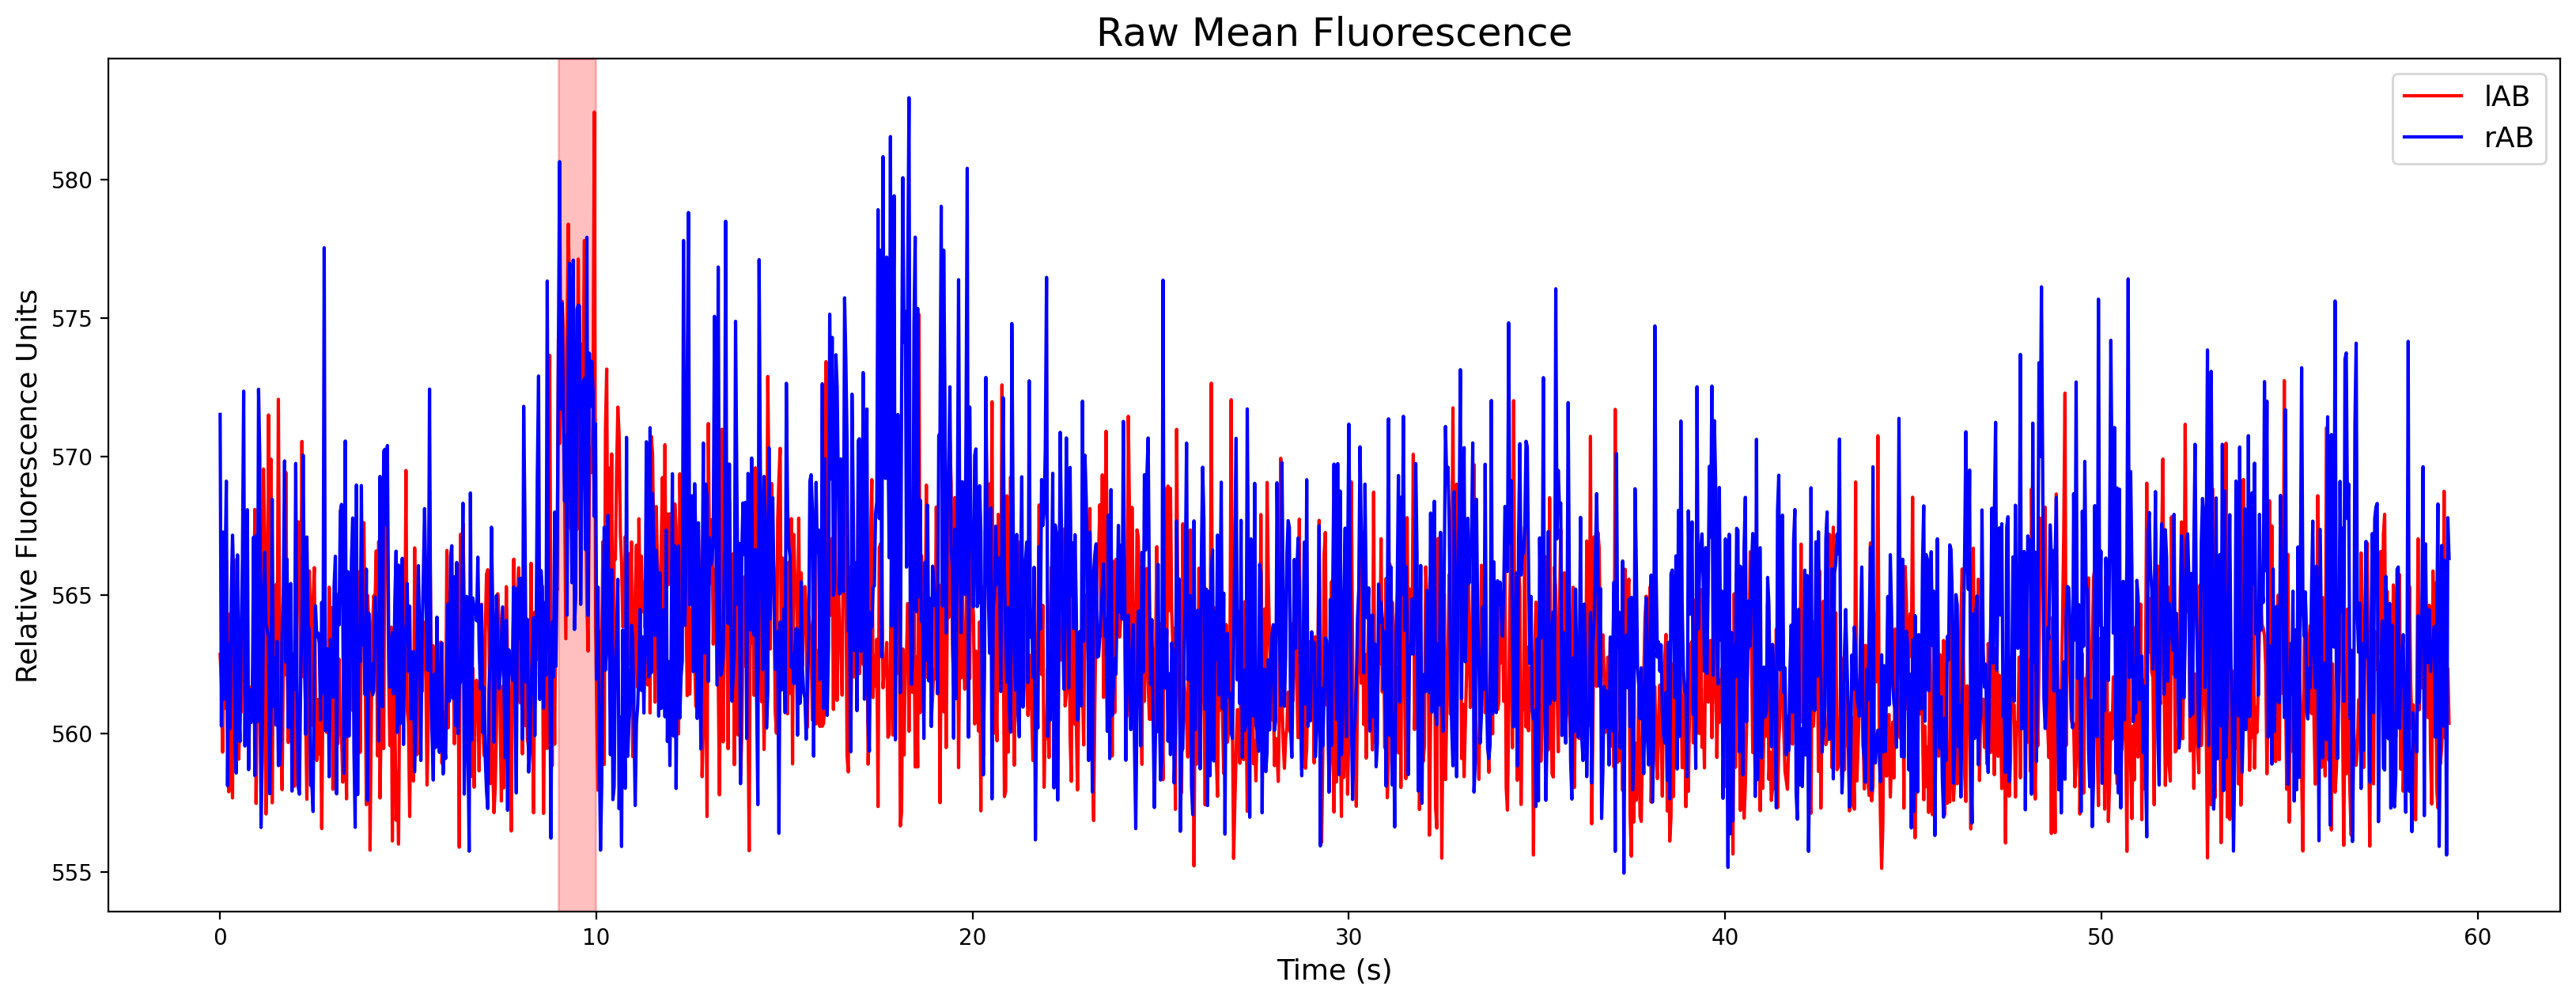

In [52]:
fig, ax = plt.subplots(figsize=(20, 7))

for idx1, sample in enumerate(np.unique(df["Channel + Sample"].values)):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["Mean pixel value in ROI1"].values
    
    ax.plot(x, y, c='red', label="lAB")

for idx2, sample in enumerate(np.unique(df["Channel + Sample"].values)):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["Mean pixel value in ROI2"].values

    ax.plot(x, y, c='blue', label="rAB")

# Add stimulation bar
for x1, x2 in zip(led_on, led_off):
    ax.axvspan(x1, x2, alpha=0.25, color='red')

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight':fontweight, 'size':fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel('Relative Fluorescence Units', fontproperties)

# Define figure title
ax.set_title('Raw Mean Fluorescence', weight='normal', size=fontsize+5)

# Add legend
ax.legend(fontsize=fontsize)

# Save figure
data_dir_name = os.path.basename(data_dir)
new_filename = f"{data_dir_name}_bkg-mean-fluorescence.png"
full_path = os.path.join(saving_dir, new_filename)

plt.savefig(fname=full_path, bbox_inches='tight', dpi=300)

fig.show()

# Plot bkg normalized mean fluorescence values over time

C:\Users\raymo\AppData\Local\Temp\ipykernel_127044\1582772159.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


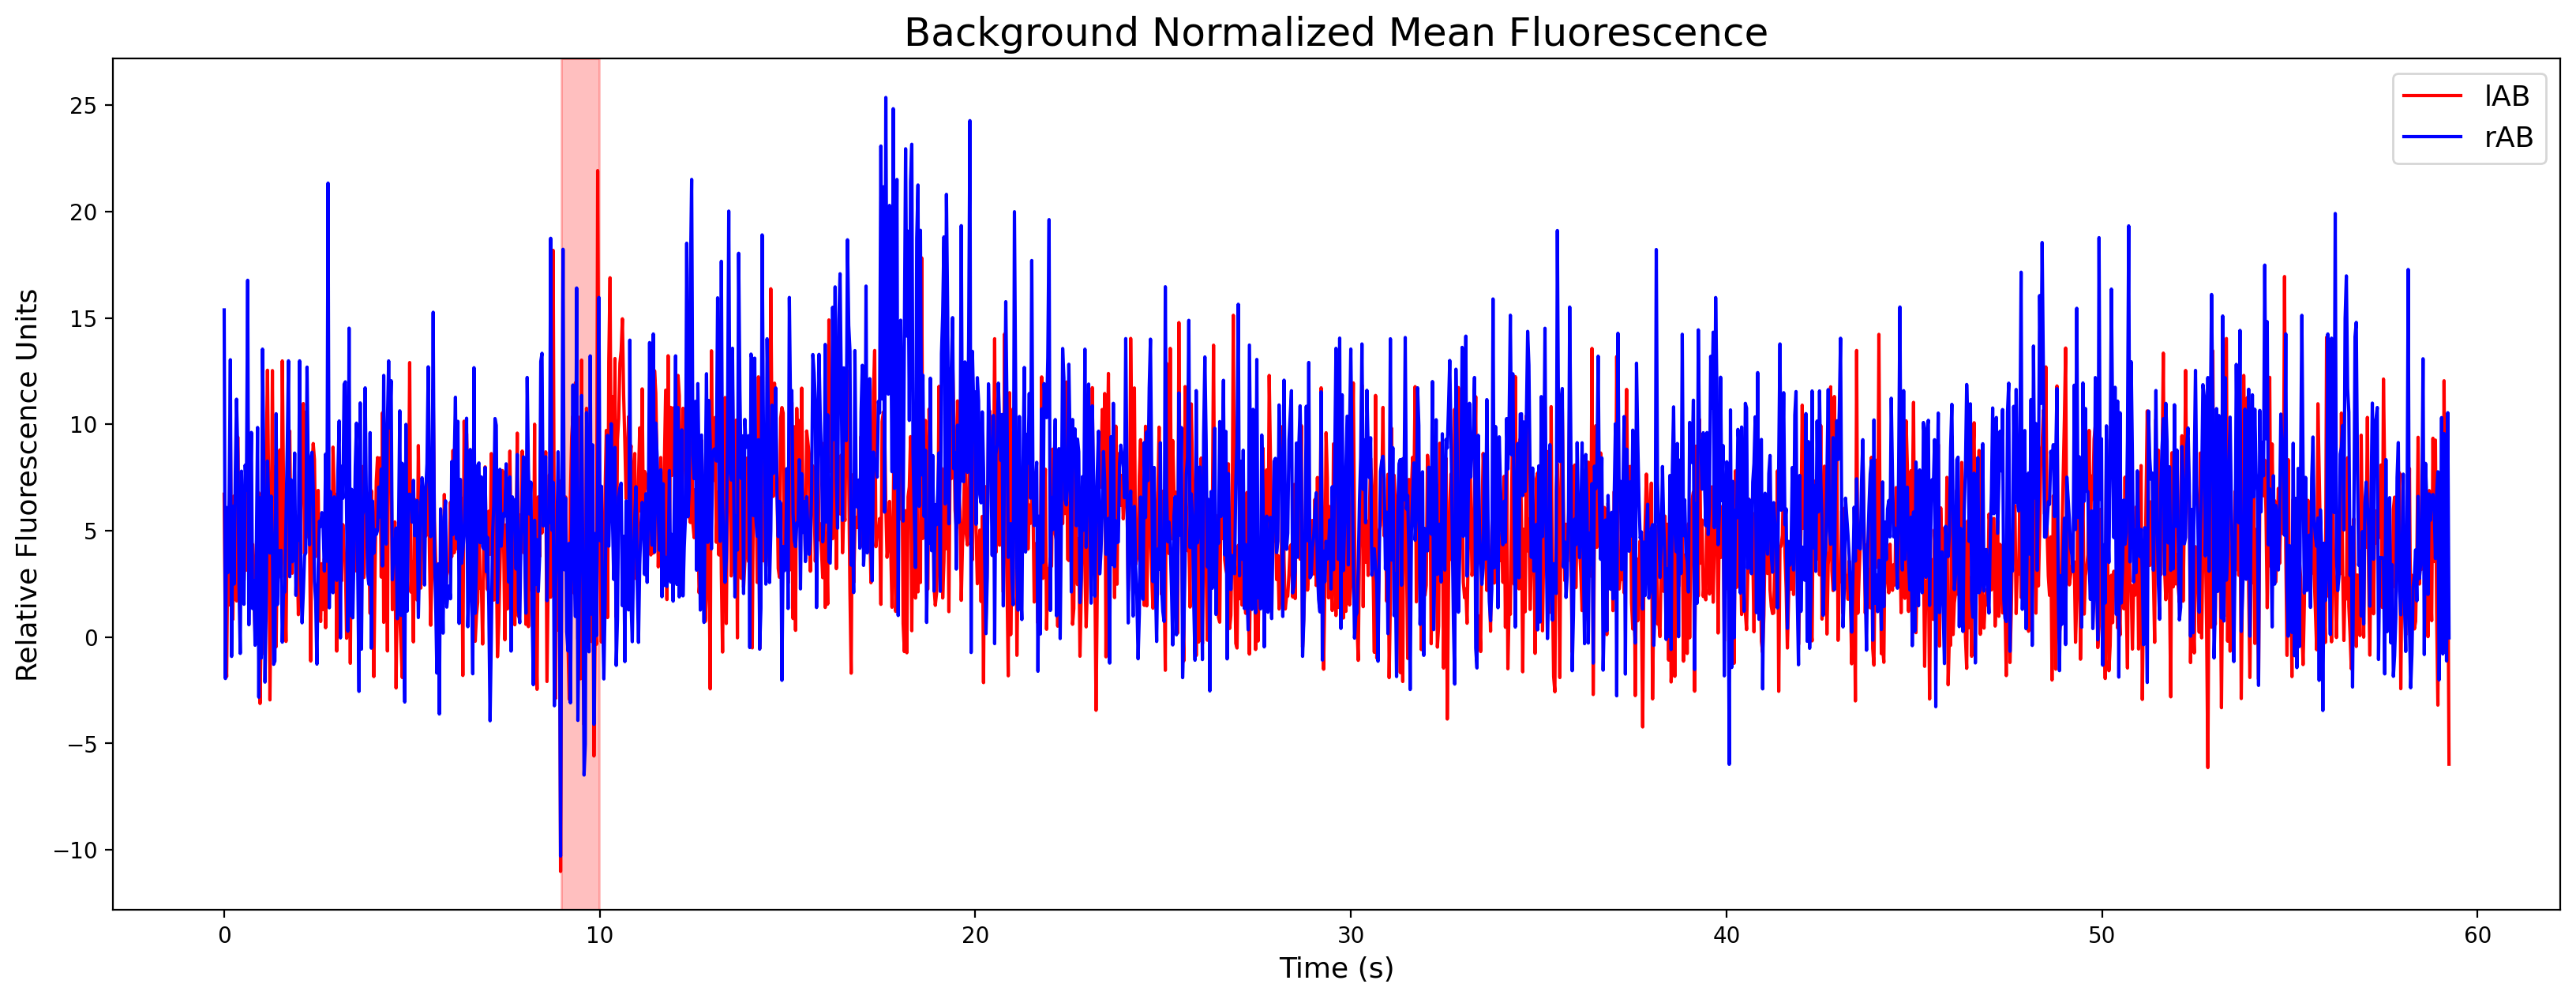

In [53]:
fig, ax = plt.subplots(figsize=(20, 7))

for idx1, sample in enumerate(np.unique(df["Channel + Sample"].values)):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["Norm_mean_pixel_value_in_ROI1"].values
    
    ax.plot(x, y, c='red', label="lAB")

for idx2, sample in enumerate(np.unique(df["Channel + Sample"].values)):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["Norm_mean_pixel_value_in_ROI2"].values

    ax.plot(x, y, c='blue', label="rAB")
    

# Add stimulation bar
for x1, x2 in zip(led_on, led_off):
    ax.axvspan(x1, x2, alpha=0.25, color='red')

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight':fontweight, 'size':fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel('Relative Fluorescence Units', fontproperties)

# Define figure title
ax.set_title('Background Normalized Mean Fluorescence', weight='normal', size=fontsize+5)

# Add legend
ax.legend(fontsize=fontsize)

# Save figure
    # Get the base name of the data directory
data_dir_name = os.path.basename(data_dir)
new_filename = f"{data_dir_name}_bkg-norm-mean-fluorescence.png"
full_path = os.path.join(saving_dir, new_filename)

plt.savefig(fname=full_path, bbox_inches='tight', dpi=300)

fig.show()


    

___

___

# Calculate $\Delta / F_0$ 

## Calculate $F_0$

Find all rows where time < time point that LED turns on:

In [54]:
df_f0 = df.query("2<`Time` < 7")

Calculate mean of bkg normalized pixel values inside ROI within first 5s and define as f0:

In [55]:
f0_L = np.mean(df_f0["Norm_mean_pixel_value_in_ROI1"].values)
f0_L

4.454438415042134

In [56]:
f0_R = np.mean(df_f0["Norm_mean_pixel_value_in_ROI2"].values)
f0_R

5.477098486621763

Add column with $\Delta F / F_0$ values to original data frame

In [57]:
df['df/f0_L'] = (df.Norm_mean_pixel_value_in_ROI1 - f0_L) / f0_L         

In [58]:
df.head()

,Filename,Channel,Sample,Time,Frame,Channel + Sample,Mean pixel value in ROI1,Mean pixel value in ROI2,Mean pixel value in bkg area,Norm_mean_pixel_value_in_ROI1,Norm_mean_pixel_value_in_ROI2,df/f0_L
0,ChanA_001_001_001,ChanA,001_001_001,0.000000,1,ChanA (001_001_001),562.860504,571.518201,556.144872,6.715632,15.373329,0.507627
1,ChanA_001_001_001,ChanA,001_001_001,0.032930,2,ChanA (001_001_001),561.885714,560.274090,562.223077,-0.337363,-1.948987,-1.075736
2,ChanA_001_001_001,ChanA,001_001_001,0.065860,3,ChanA (001_001_001),559.332773,567.278373,561.191026,-1.858253,6.087347,-1.417169
3,ChanA_001_001_001,ChanA,001_001_001,0.098791,4,ChanA (001_001_001),563.163025,561.239829,558.211538,4.951487,3.028290,0.111585
4,ChanA_001_001_001,ChanA,001_001_001,0.131721,5,ChanA (001_001_001),560.915966,565.880086,559.406410,1.509556,6.473675,-0.661112


In [59]:
df['df/f0_R'] = (df.Norm_mean_pixel_value_in_ROI2 - f0_R) / f0_R  

In [60]:
df.head()

,Filename,Channel,Sample,Time,Frame,Channel + Sample,Mean pixel value in ROI1,Mean pixel value in ROI2,Mean pixel value in bkg area,Norm_mean_pixel_value_in_ROI1,Norm_mean_pixel_value_in_ROI2,df/f0_L,df/f0_R
0,ChanA_001_001_001,ChanA,001_001_001,0.000000,1,ChanA (001_001_001),562.860504,571.518201,556.144872,6.715632,15.373329,0.507627,1.806838
1,ChanA_001_001_001,ChanA,001_001_001,0.032930,2,ChanA (001_001_001),561.885714,560.274090,562.223077,-0.337363,-1.948987,-1.075736,-1.355843
2,ChanA_001_001_001,ChanA,001_001_001,0.065860,3,ChanA (001_001_001),559.332773,567.278373,561.191026,-1.858253,6.087347,-1.417169,0.111418
3,ChanA_001_001_001,ChanA,001_001_001,0.098791,4,ChanA (001_001_001),563.163025,561.239829,558.211538,4.951487,3.028290,0.111585,-0.447100
4,ChanA_001_001_001,ChanA,001_001_001,0.131721,5,ChanA (001_001_001),560.915966,565.880086,559.406410,1.509556,6.473675,-0.661112,0.181953


# Plot $\Delta F / F_0$ 

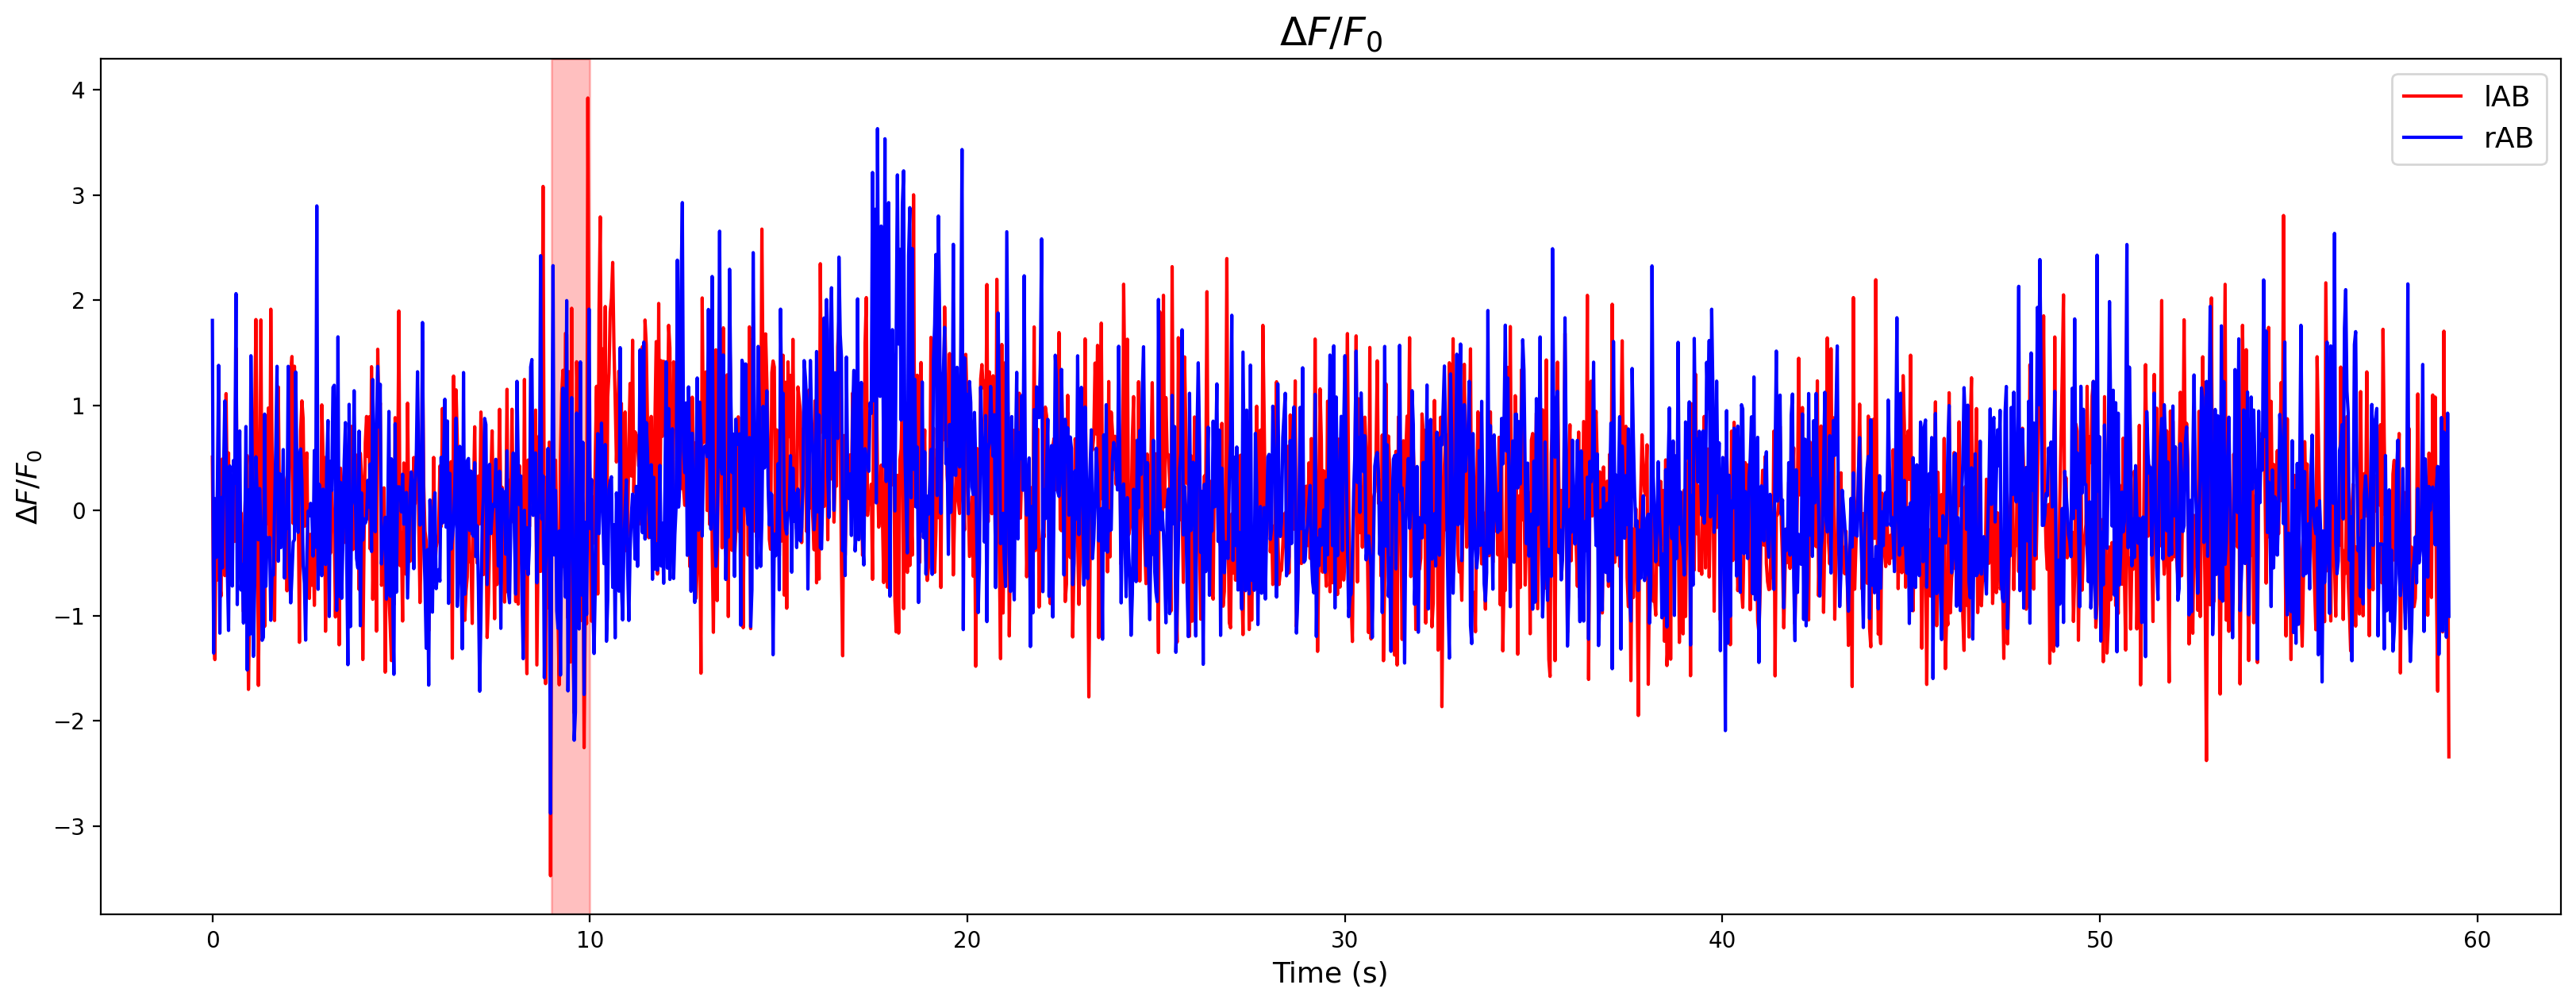

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os

fig, ax = plt.subplots(figsize=(20, 7))

# Plot lAB data
for sample in np.unique(df["Channel + Sample"].values):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["df/f0_L"].values
    ax.plot(x, y, c='red', label="lAB")

# Plot rAB data
for sample in np.unique(df["Channel + Sample"].values):
    x = df[df["Channel + Sample"]==sample]["Time"].values
    y = df[df["Channel + Sample"]==sample]["df/f0_R"].values
    ax.plot(x, y, c='blue', label="rAB")

# Add stimulation bar
for x1, x2 in zip(led_on, led_off):
    ax.axvspan(x1, x2, alpha=0.25, color='red')

# Set axis labels
fontsize = 13
fontweight = 'normal'
fontproperties = {'weight': fontweight, 'size': fontsize}
ax.set_xlabel('Time (s)', fontproperties)
ax.set_ylabel(r'$\Delta F / F_0$', fontproperties)

# Define figure title
ax.set_title(r'$\Delta F / F_0$', weight='normal', size=fontsize+5)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=fontsize)

# Save figure
data_dir_name = os.path.basename(data_dir)
new_filename = f"{data_dir_name}_df-f0.png"
full_path = os.path.join(saving_dir, new_filename)
plt.savefig(fname=full_path, bbox_inches='tight', dpi=300)

plt.show()

___

Add LED column to data frame:

In [62]:
import pandas as pd
import numpy as np

# Add column called "LED" to dataframe filled with 0s
df["LED"] = 0

# Create a boolean mask for LED on periods
led_mask = np.zeros(len(df), dtype=bool)

for start, end in zip(led_on, led_off):
    led_mask |= (df["Time"] >= start) & (df["Time"] < end)

# Set LED column to 1 where the mask is True
df.loc[led_mask, "LED"] = 1

# Verify the results
print(df[["Time", "LED"]].head(20))  # Adjust the number as needed to see relevant rows
print(f"\nTotal LED on time points: {df['LED'].sum()}")

        Time  LED
0   0.000000    0
1   0.032930    0
2   0.065860    0
3   0.098791    0
4   0.131721    0
5   0.164651    0
6   0.197581    0
7   0.230512    0
8   0.263442    0
9   0.296372    0
10  0.329302    0
11  0.362232    0
12  0.395163    0
13  0.428093    0
14  0.461023    0
15  0.493953    0
16  0.526884    0
17  0.559814    0
18  0.592744    0
19  0.625674    0

Total LED on time points: 31


# Save data frame to csv

In [63]:

data_dir_name = os.path.basename(data_dir)
new_filename = f"{data_dir_name}_2-photon_fluorescence_analysis.csv"
full_path = os.path.join(saving_dir, new_filename)
df.to_csv(full_path, index=False)

___

# Pickle dictionary containing images and clicks for later use
This dictionary contains the original iamge stacks, sum fluorescence images, names of the images, clicks as data frame, rois and the sum of the pixel intensity values inside the roi for each individual stack.   

In [64]:
path = ("{}").format(saving_dir)

In [65]:
# Create the filename
filename = f"{os.path.basename(data_dir)}_2-photon_fluorescence_analysis.pickle"

# Create the full path
full_path = os.path.join(saving_dir, filename)

# Save the dictionary using pickle
with open(full_path, "wb") as handle:
    pickle.dump(dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)



___

# Plot heatmaps

In [66]:
# Find number of pixels (assuming square image)
pixels = len(imagedata["matrix_orig"][0])


Find mean pixel value in backgrgound area for each frame:

In [67]:
# Make another image stack where each image is of size 512,512 and filled with the average value on the background ROI for that frame
MEAN = [np.ones((pixels, pixels))*i for i in imagedata["mean_int_bkg"]]


In [68]:
# X is our original z-stack
X = np.array(imagedata["matrix_orig"])

In [69]:
# Y is the z-stack where each pixel value is subtracted by the mean pixel value in the background
Y_orig = X-MEAN


In [70]:
# Find the minimum value in the array
min_value = np.min(Y_orig)

# Shift the array so that the minimum value becomes 0
Y = Y_orig - min_value
#X[X<0] = 0
# DEBUG: Check the range of values in Y
print(f"Y range: {Y.min()} to {Y.max()}")
#print(f"X range: {x.min()} to {X.max()}")

Y range: 0.0 to 3879.9769230769234


Find frames before LED turns on:

I define F0 as mean value of each pixel in frames 0 - five frames before LED turns on:

In [71]:
if len(led_on) == 1: # LED turns on only once
    frame_on = np.array(np.argwhere(imagedata["time_points"]<led_on).reshape(-1))[-5]

else: # LED turns on more than once
    frame_on = np.array(np.argwhere(imagedata["time_points"]<led_on[0]).reshape(-1))[-5]



In [72]:
F0 = Y[0:frame_on,:,:].mean(axis=0)
#F0 = X[0:frame_on,:,:].mean(axis=0)
# DEBUG: Check F0 values
print(f"F0 range: {F0.min()} to {F0.max()}")

F0 range: 557.2524875621895 to 676.2039800995028


Calculate df/f0 z-stack:

In [73]:
mtx = (Y-F0)/F0
mtx_peak = (Y[260:450,:,:]-F0)/F0
#mtx = (X-F0)/F0
# DEBUG: Check mtx values
print(f"mtx range: {mtx.min()} to {mtx.max()}")

mtx range: -1.0 to 5.946318744817472


Uncomment the two cells below to apply the ROI mask drawn above to see only this ROI in the heat map:

In [74]:
# # Create array containing z copies of mask to match shape of Y
#mask1 = []
#mask2 = []
#maskbkg = []
#for i in np.arange(len(Y)):
     #mask1.append(imagedata["roi1_mask"])
     #mask2.append(imagedata["roi2_mask"])
     #maskbkg.append(imagedata["roisbkg_mask"])

In [75]:
#mtx[~np.array(mask1)] = 0
#mtx[~np.array(mask2)] = 0
#mtx[~np.array(maskbkg)] = 0

## Plot sum projection of heat map

Plotted range: -0.012225255480031666 to 5.946318744817472


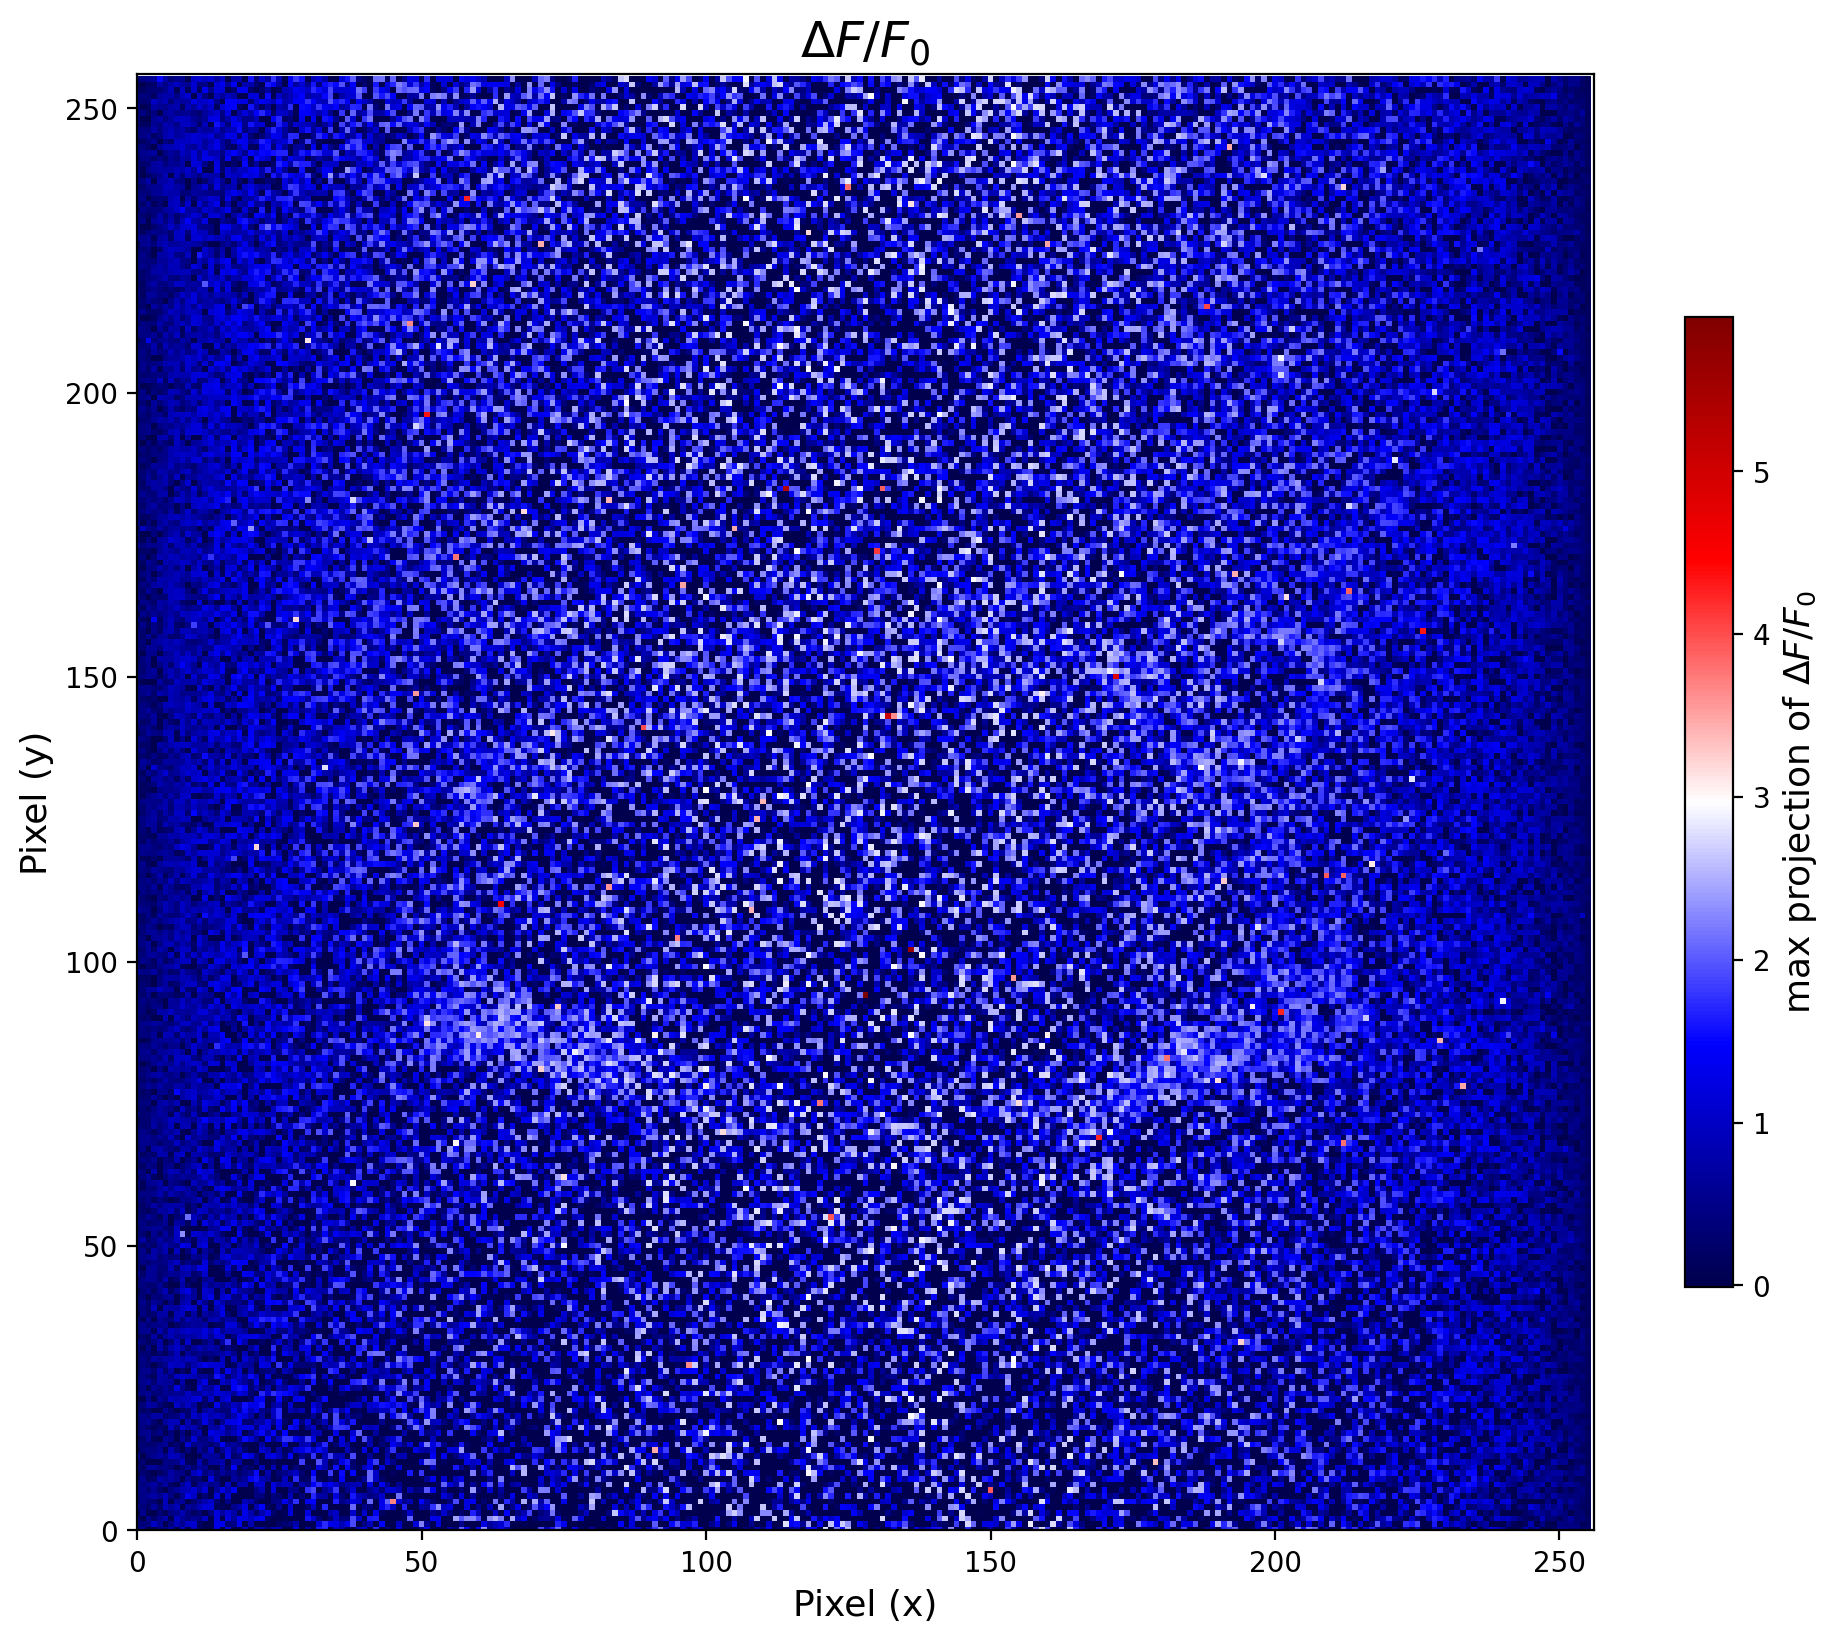

ΔF/F₀ range: -0.84 to 5.95


In [76]:
fig, ax = plt.subplots(figsize=(10,10))

im = plt.imshow(mtx_peak.max(axis=0), origin='lower', cmap="seismic")
# DEBUG: Check the range of values being plotted
print(f"Plotted range: {mtx_peak.max(axis=0).min()} to {mtx_peak.max(axis=0).max()}")
#Set zoom
ax.set_xlim((0,pixels))
ax.set_ylim((0,pixels))

fontsize = 13

# Set axis labels
ax.set_xlabel('Pixel (x)', fontsize=fontsize)
ax.set_ylabel('Pixel (y)', fontsize=fontsize)

# Add heatmap legend
plt.colorbar(shrink=0.5).set_label(r'max projection of $\Delta F / F_0$', fontsize=fontsize)

ax.set_title(r"$\Delta F / F_0$", weight='bold', fontsize=fontsize+5)


# Save figure
data_dir_name = os.path.basename(data_dir)
new_filename = f"{data_dir_name}_df-f0_heatmap_max_260-450.png"
full_path = os.path.join(saving_dir, new_filename)
plt.savefig(fname=full_path, bbox_inches='tight', dpi=300)

fig.tight_layout()
plt.show()

print(f"ΔF/F₀ range: {mtx_peak.min():.2f} to {mtx_peak.max():.2f}")

## Plot animated heatmap

In [77]:
%matplotlib tk
a = mtx

fig, ax = plt.subplots(figsize=(7,5))

frame = 0
idx = 0

im = plt.imshow(a[frame], origin='lower', cmap="seismic")

ax.set_xlabel('Pixel (x)')
ax.set_ylabel('Pixel (y)')

plt.colorbar(shrink=0.5).set_label(r'$\Delta F / F_0$')

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='white')
circle = plt.Circle((0.9, 0.9), 0.05, color='r', transform=ax.transAxes)
circle_status = False

def update(*args):
    global frame
    global idx 
    global circle_status
    
 # Check if we've reached the end of the data
    if idx >= len(df):
        # Reset to the beginning or stop the animation
        idx = 0
        frame = 0
        # Optionally, you could stop the animation here:
        # ani.event_source.stop()
        # return im
    
    im.set_array(np.flipud(a[frame]))
    
    if df["LED"].values[idx] == 1:
        if not circle_status:
            ax.add_artist(circle)
            circle_status = True
            print("Turned ON")
    elif df["LED"].values[idx] == 0:
        if circle_status:
            circle.remove()  # Remove the circle instead of just hiding it
            print("Turned OFF")
            circle_status = False

    frame = (frame + 1) % len(a)
    time_text.set_text('Time in s: %.1f' % df["Time"].values[idx])
    idx += 1
    
    return im

ani = animation.FuncAnimation(fig, update, frames=len(a), interval=50, repeat=False)

import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
new_filename = f"{data_dir_name}__df-f0_heatmap_movieHM.mp4"
full_path = os.path.join(saving_dir, new_filename)
ani.save(filename=full_path, writer=writer)

plt.show()


Turned ON
Turned OFF
Turned ON
Turned OFF


___

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,skimage,bokeh,bebi103,jupyterlab